In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [8]:
level=7
fileidx=63

f=h5py.File('GadgetOutputs\level%d\snapshot_%03d.hdf5'%(level,fileidx),'r')
Loc=np.array(f['PartType1']['Coordinates'])
ParticleIDs=np.array(f['PartType1']['ParticleIDs'])
currentz=dict(f['Header'].attrs)['Redshift']
Ndim=int(np.cbrt(dict(f['Header'].attrs)['NumPart_Total'][1]))
celllen=dict(f['Header'].attrs)['BoxSize']/Ndim # length of cell

In [9]:
# Lagrangian grid points
x = celllen*(0.5+np.arange(Ndim))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
gridPoints=np.vstack([xl,yl,zl]).transpose()


#sort the particles according to ID
Loc_sorted=np.copy(Loc)
Loc_sorted[ParticleIDs]=Loc

#take care of the periodic boundary
delta=Loc_sorted - gridPoints
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -20.0
    too_big = delta[:,dim] > 20.0
    Loc_shifted[too_big,dim] -= 40.0
    Loc_shifted[too_small,dim] += 40.0
    
# reshape the particles into a mesh
grid3d=np.stack(xg,axis=3)
Loc3d=Loc_shifted.reshape(Ndim,Ndim,Ndim,3) 

In [10]:
def get_tet_volumes(Ndim,p3d):
    """A fast function to compute the volumes of all tetrahedra"""
    vert = np.array(( (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1) ))
    conn = np.array( ( (1,0,2,4), (3,1,2,4), (3,5,1,4), (3,6,5,4), (3,2,6,4), (3,7,5,6) ))
    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    vol = np.zeros((Ndim,Ndim,Ndim, Ntetpp))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        b = np.cross(b,c)
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))        
        vol[:,:,:,m] = (-np.sum(a*b,axis=1)/6.).reshape((Ndim,Ndim,Ndim))
    return vol

def get_tet_centroids(Ndim,p3d):
    """ A fast function to compute the centroids of all tetrahedra """
    vert = np.array(( (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1) ))
    conn = np.array( ( (1,0,2,4), (3,1,2,4), (3,5,1,4), (3,6,5,4), (3,2,6,4), (3,7,5,6) ))
    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    cen = np.zeros((Np*Ntetpp,3))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        orig = p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - orig ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - orig ).reshape((Np,3))
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - orig).reshape((Np,3))   
        cen[m::Ntetpp,:] = orig.reshape(Np,3) + ((a+b+c)/4.)
    return cen


In [11]:
vol = get_tet_volumes(Ndim-1,Loc3d)
cen = get_tet_centroids(Ndim-1,Loc3d)
volflat=vol.reshape(((Ndim-1)**3,6))
mvol = np.fabs(volflat )/(celllen**3) # every particle in ICs has volume of 1 this way 

In [12]:
vert = np.array(( (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1) ))
conn = np.array( ( (1,0,2,4), (3,1,2,4), (3,5,1,4), (3,6,5,4), (3,2,6,4), (3,7,5,6) ))

# now we need to, for a grid point (for simplicity, only in bulk), find the tetrahedra connected to it
possib_cell_shift=np.array(( (0,0,0), (0,0,-1), (0,-1,0), (0,-1,-1), (-1,0,0), (-1,0,-1), (-1,-1,0), (-1,-1,-1) ))
#to specify a tetrahedron, specify the cell and which of the 6 tetrahedra it is 
cell_shifts=[]
tetra_nos=[]
# find all tetrahedra connected to [0,0,0]
for shift in possib_cell_shift:
    for nn in range(len(conn)):
        flag=0
        for vertidx in conn[nn]:
            if np.prod((shift+vert[vertidx]) == np.zeros(3)):
                # when a vertice of that tetrahedra in the shifted cell is the origin
                cell_shifts.append(shift)
                tetra_nos.append(nn)

# collect all bulk points
tmp=np.array(range(1,Ndim-1))
bulk_mesh = np.meshgrid(tmp,tmp,tmp, indexing='ij')
bulk_mesh=np.stack(bulk_mesh,axis=3)
bulkPoints = bulk_mesh.reshape((Ndim-2)**3,3)
bulkids = bulkPoints[:,0]*(Ndim-1)**2 + bulkPoints[:,1]*(Ndim-1) + bulkPoints[:,2]

# sum over all tetrahedra connected to bulk points
totV=np.zeros((Ndim-2)**3)
for idx in range(len(cell_shifts)): # 24 connected tetrahedra
    shift=cell_shifts[idx]
    idshift= shift[0]*(Ndim-1)**2 + shift[1]*(Ndim-1) + shift[2]
    totV+=mvol[bulkids+idshift,tetra_nos[idx]]

# primordial density
primDen=4/totV # each grid point is connected to 24 tetrahedra, while each tetrahedra carry 1/6 particle mass

Text(0, 0.5, '$ dM/ d\\log \\rho $')

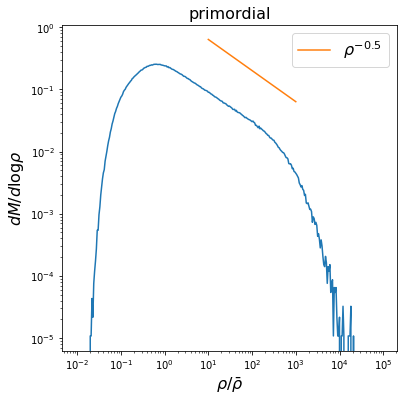

In [13]:
#plot distribution

dm,rhobins=np.histogram(primDen,bins=np.power(10.0,np.arange( -2,5, 0.02 )))
dlogrho=(np.log(rhobins)[1]-np.log(rhobins)[0]) 
rhoxaxis=rhobins[0:dm.shape[0]]
plt.figure().set_size_inches([6,6])
plt.loglog(rhoxaxis,dm/dlogrho/len(primDen)) # /len(primDen) to normalize
plt.loglog([10,1000],2*np.power([10,1000],-0.5),label='$\\rho^{-0.5}$')
plt.legend(fontsize=16)
plt.title('primordial',fontsize=16)

plt.xlabel('$\\rho/\\bar {\\rho}$',fontsize=16)
plt.ylabel('$ dM/ d\\log \\rho $',fontsize=16)

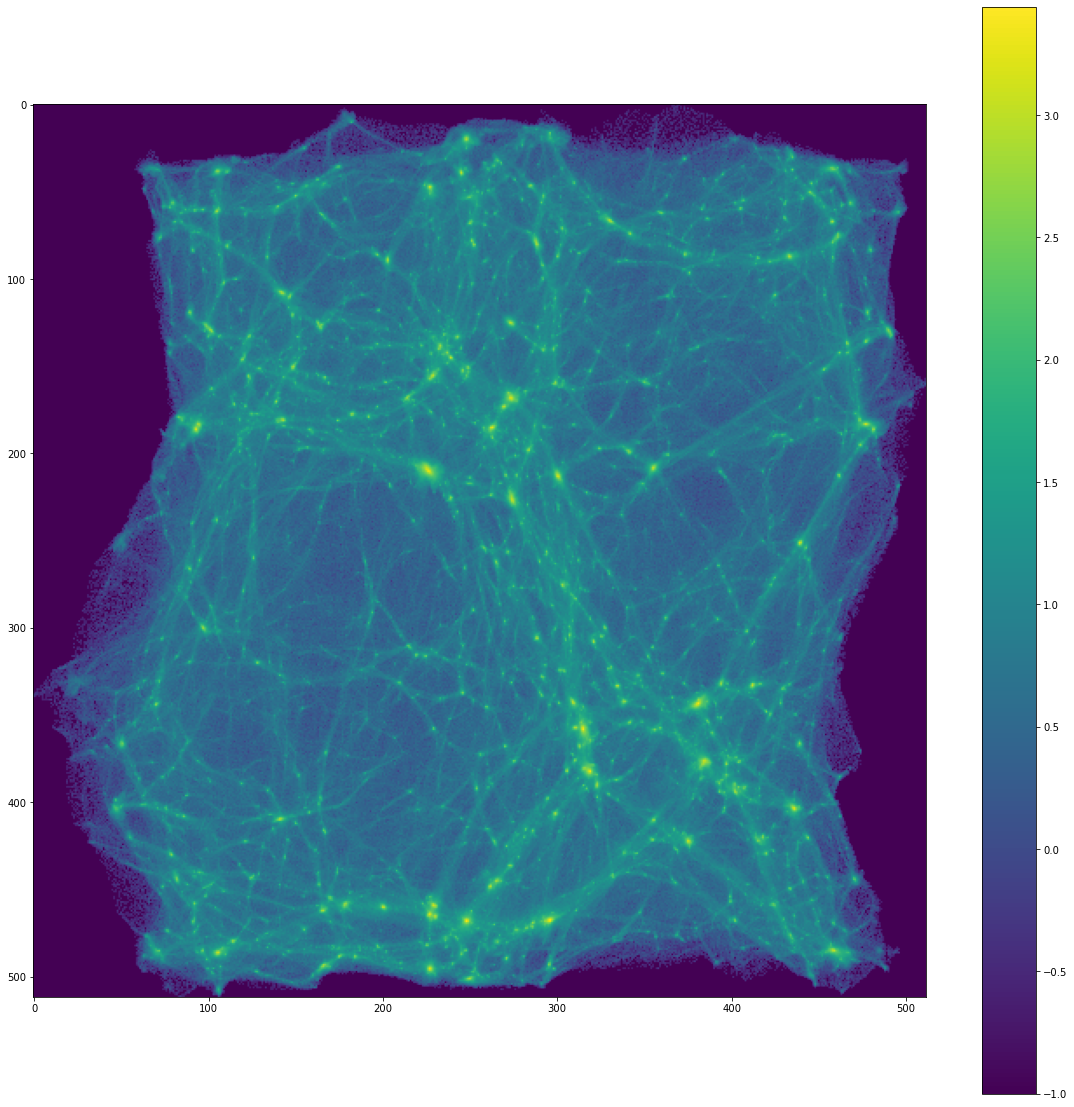

In [14]:
H, edges = np.histogramdd([cen[:,0],cen[:,1]],bins=(4*Ndim,4*Ndim))
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log10(H/6.+1e-1))
plt.colorbar();

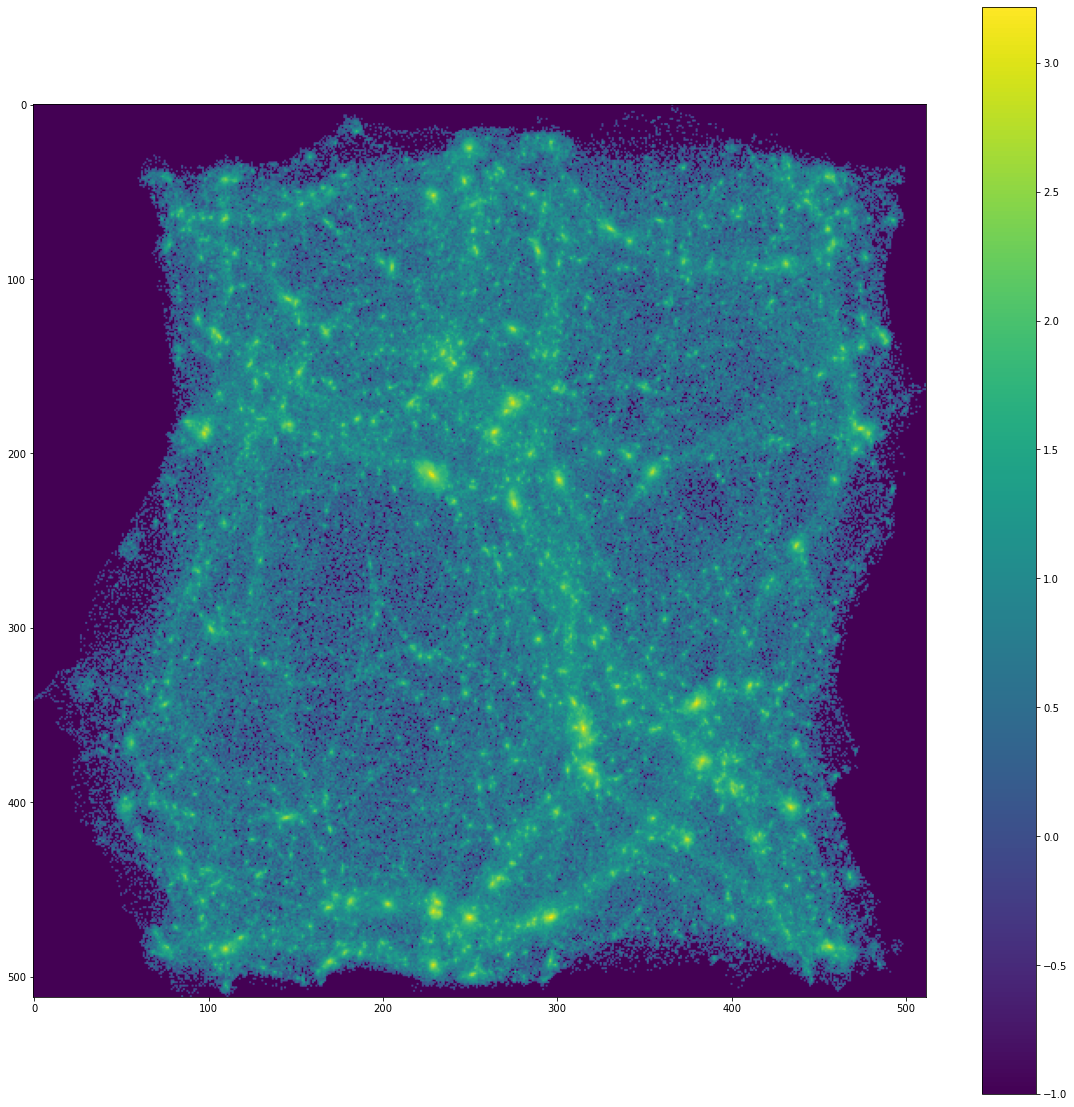

In [16]:
fig = plt.figure(figsize=(20,20))
H, edges = np.histogramdd([Loc_shifted[:,0],Loc_shifted[:,1]],bins=(4*Ndim,4*Ndim))
plt.imshow(np.log10(H+1e-1))
plt.colorbar();